## Minor Allele Frquency plots

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict
from emd_func import compute_pymed_emd
from plot_func import plot_emd, plot_sorted
from coverage_func import plot_scatter, subplot_scatter
from outliers_func import remove_outliers
from trunc_mean_func import truncated_mean
from boxplot_func import create_sns_table_from_big_dict, create_sns_table_from_flat_dict, plot_box_plot

from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>");

In [24]:
#Reading the dictionary data file
curr_dir = !pwd
my_path = curr_dir[0]+"/../7.filters/filtered_dicts/"
with open(my_path+'zinc_hmm_states_dict_JSD_SE_9.30_cov-filter.pik', 'rb') as handle:
    states_dict = pickle.load(handle)

#Getting the number of states for this domain
states_num = len(states_dict.keys())

In [25]:
### Creating flat dictionaries
#Create a dictionary for AF values only
states_af_dict = defaultdict(list)
for state in states_dict.keys():
    for d in states_dict[state]:
        states_af_dict[state].append(d["af"])

#Create a dictionary for AF adjusted values only
states_af_adj_dict = defaultdict(list)
for state in states_dict.keys():
    for d in states_dict[state]:
        states_af_adj_dict[state].append(d["af_adj"])

In [26]:
#Create a dictionary for Coverage values only
states_mean_cov_dict = defaultdict(list)
for state in states_dict.keys():
    for d in states_dict[state]:
        states_mean_cov_dict[state].append(d["coverage_mean"])

In [27]:
#Scaling the MAF
states_MAF_adj_dict_scaled = defaultdict(list)
for state in states_dict.keys():
    state_len = len(states_dict[state])
    for d in states_dict[state]:
        states_MAF_adj_dict_scaled[state].append(float(d["af_adj"]/state_len))

### MAF EMD plots

EMD between MAF and all 0s distribution. EMD for each HMM state individually.

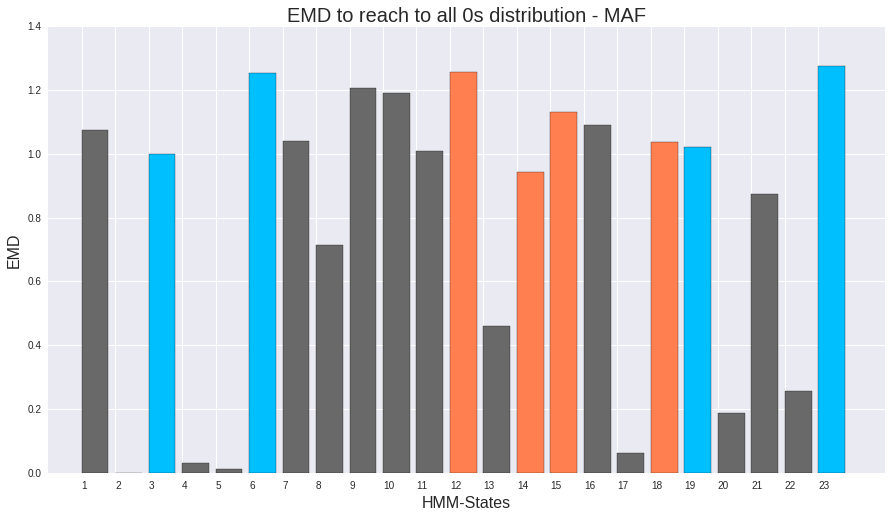

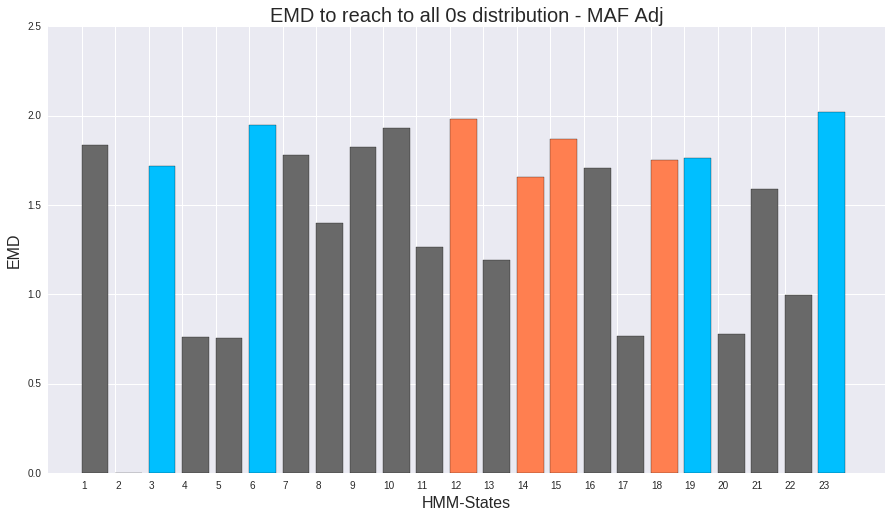

In [5]:
#MAF EMD
af_emd_dict = compute_pymed_emd(states_af_dict, 1000)
plot_emd(af_emd_dict, "MAF", curr_dir, "SNP_Zinc_filter_MAF_EMD", True, False)

#MAF adj EMD
af_adj_emd_dict = compute_pymed_emd(states_af_adj_dict, 1000)
plot_emd(af_adj_emd_dict, "MAF Adj", curr_dir, "Zinc_filter_MAF_Adj_EMD", True, False)

### States sorted by different parameters

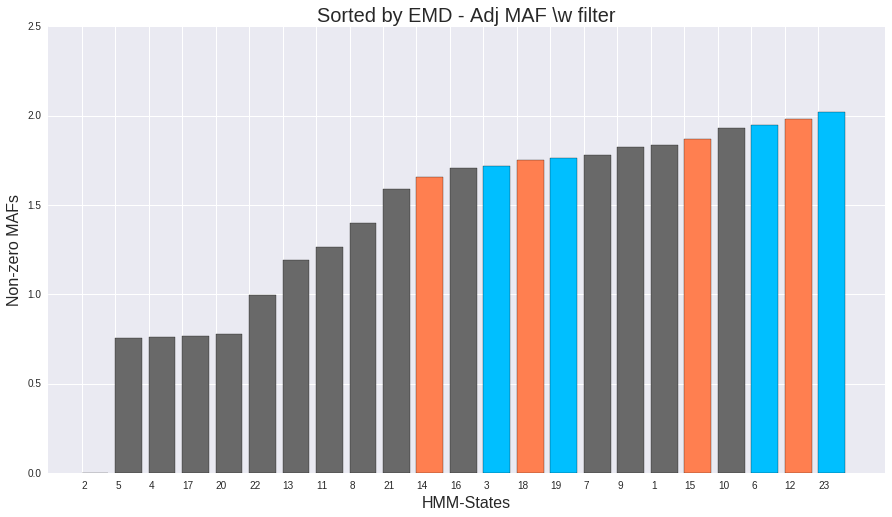

In [6]:
#Adj MAF Sort the states by EMD
plot_sorted(af_adj_emd_dict, "Sorted by EMD", "Adj MAF \w filter", curr_dir, "Sorted_EMD_MAF_Adj_filter", True, False)

In [7]:
#Count the number of non-zero Adj MAF
non_zero_adj_af = [0] * states_num
for state in states_dict.keys():
    for d in states_dict[state]:
        if (d["af_adj"] != 0):
            non_zero_adj_af[state-1] += 1

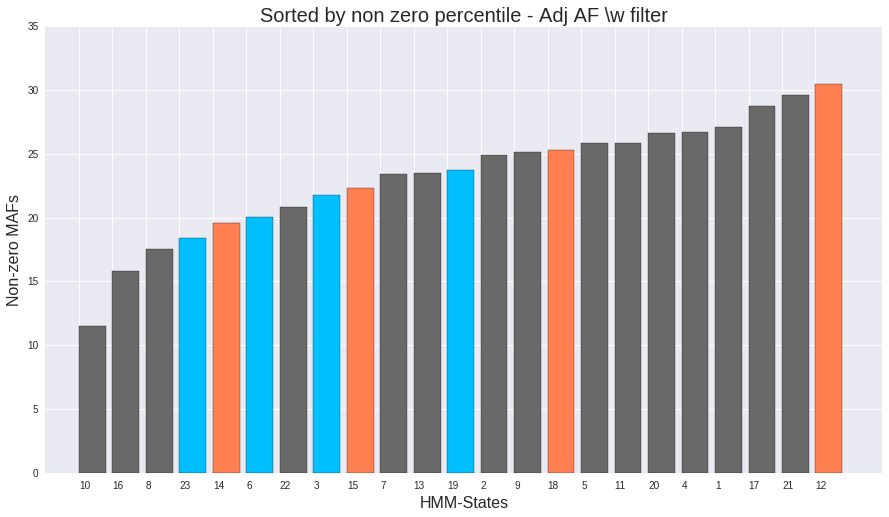

In [8]:
non_zero_percentile = {}
for state in states_dict.keys():
    frac = non_zero_adj_af[state-1]/float(len(states_dict[state]))
    perc = frac * 100
    non_zero_percentile[state] = perc
plot_sorted(non_zero_percentile, "Sorted by non zero percentile", "Adj AF \w filter", curr_dir, "Non_zero_percent", False, False)

### Coverage scatter plots

MAF plots for each state, and coverage. Checking if outliers are a result of bad coverage.

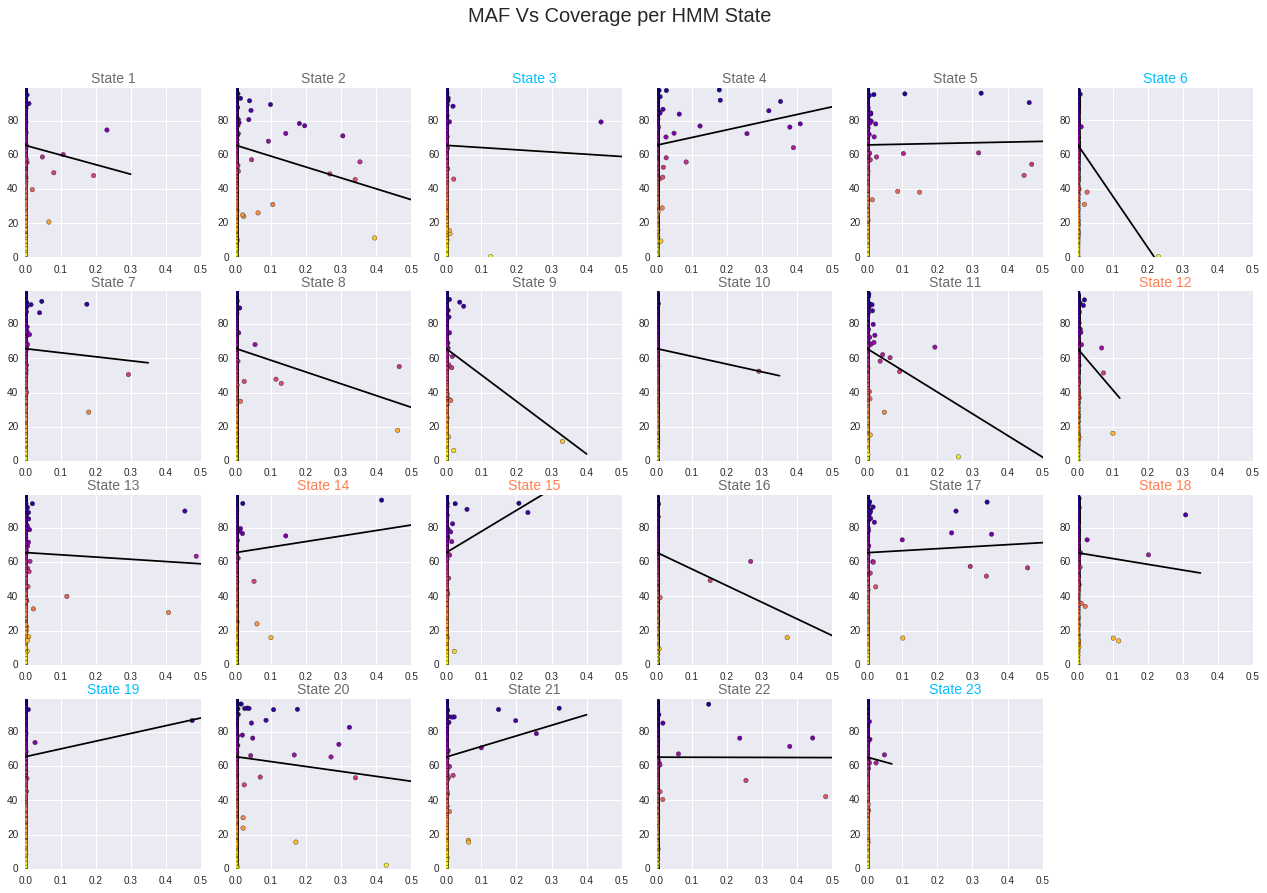

In [9]:
#Create a MAF Coverage scatter subplot for each state
plt.figure(figsize=(22,14))

colors = ['dimgrey', 'dimgrey', 'deepskyblue', 'dimgrey', 'dimgrey', 'deepskyblue', 'dimgrey', 'dimgrey', 'dimgrey', 'dimgrey', 'dimgrey', 'coral', 
              'dimgrey', 'coral', 'coral', 'dimgrey', 'dimgrey', 'coral', 'deepskyblue', 'dimgrey', 'dimgrey', 'dimgrey', 'deepskyblue']

for state in states_af_adj_dict.keys():
    state_af = states_af_adj_dict[state]
    state_cov_mean = states_mean_cov_dict[state]
    subplot_num = int("46"+str(state))
    plt.subplot(4, 6, state)
    subplot_scatter(state_af, state_cov_mean, "State "+str(state), colors[state-1])

#plt.text(0.5, 0.5, 'common X', ha='center', fontsize=10)
#plt.text(0.04, 0.5, 'common Y', va='center', rotation='vertical', fontsize=10)
plt.suptitle("MAF Vs Coverage per HMM State", fontsize=20)
plt.savefig(curr_dir[0]+"/plots/MAF_cov_per_state.pdf", bbox_inches="tight")
plt.show()

### Removing outliers

Removing from each state the data points that are 2 std from the mean. Then calculating EMD again.

In [10]:
no_outliers_af_adj_dict = remove_outliers(states_af_adj_dict)
no_outliers_af_adj_emd_dict = compute_pymed_emd(no_outliers_af_adj_dict, 1000)

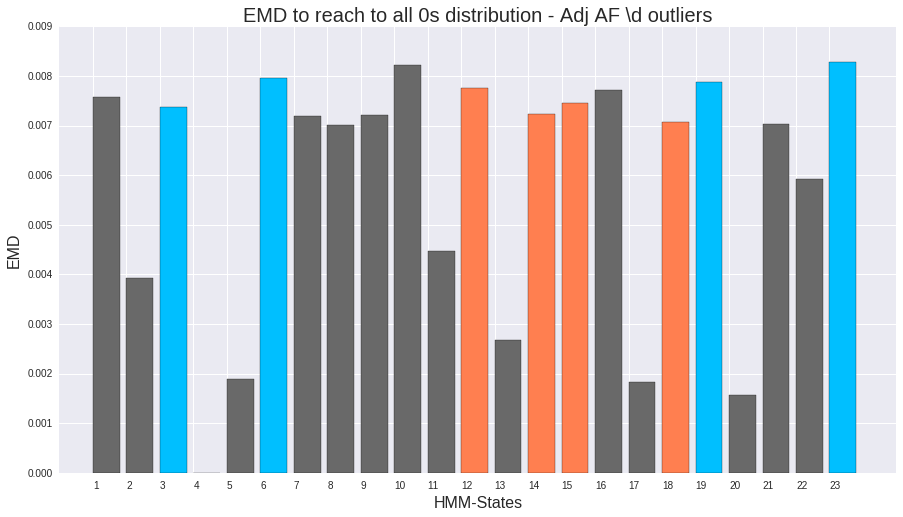

In [11]:
plot_emd(no_outliers_af_adj_emd_dict, "Adj AF \d outliers", curr_dir, "no_outliers_adj_af_EMD", True, False)

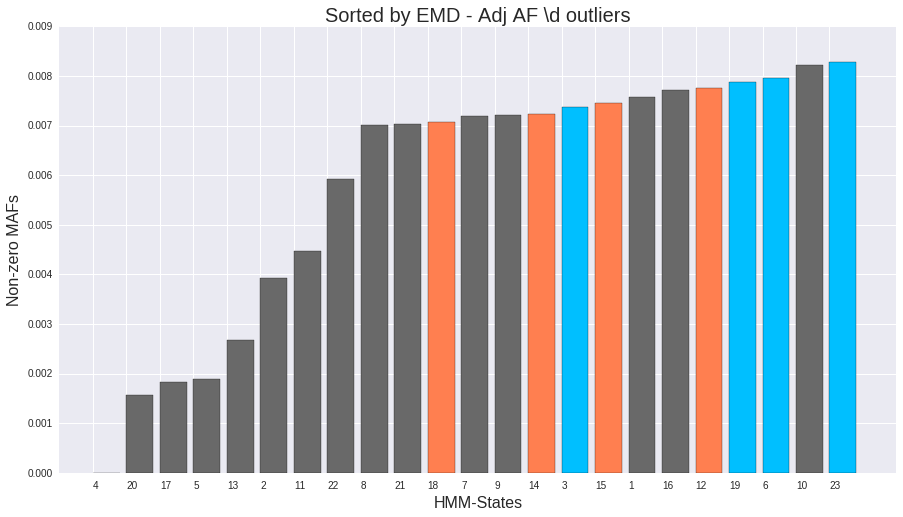

In [12]:
#Adj MAF no outliers Sort the states by EMD
plot_sorted(no_outliers_af_adj_emd_dict, "Sorted by EMD", "Adj AF \d outliers", curr_dir, "Sorted_EMD_MAF_Adj_outliers_filter_rev", True, False)

### Trim 0s before calculating EMD

Find the lowest number of 0s in a distribution. Remove this number of 0s from all distriubtions. Then, calculate EMD and try to see boxplots and medians.
This isn't good for cases usch as state #12: high number of non-zero low values.

In [9]:
#Count the number of zero Adj MAF
zero_adj_af = [0] * states_num
for state in states_dict.keys():
    for d in states_dict[state]:
        if (d["af_adj"] == 0):
            zero_adj_af[state-1] += 1

In [10]:
min_0s = min(zero_adj_af)

In [11]:
#Trim each state by the same number of data points
states_dict_0s = states_dict.copy()
for state in states_dict_0s.keys():
    #Sort the state list
    state_sorted = sorted(states_dict_0s[state], key=lambda k: k['af_adj'])
    states_dict_0s[state] = state_sorted[min_0s:]

In [12]:
maf_med = []
for state in states_dict_0s.keys():
    mafs = []
    for d in states_dict_0s[state]:
        mafs.append(d["af_adj"])
    maf_med.append(np.median(mafs))

In [13]:
#Create a dictionary for MAF adj values only
states_MAF_adj_dict_0s = defaultdict(list)
for state in states_dict_0s.keys():
    for d in states_dict_0s[state]:
        states_MAF_adj_dict_0s[state].append(d["af_adj"])

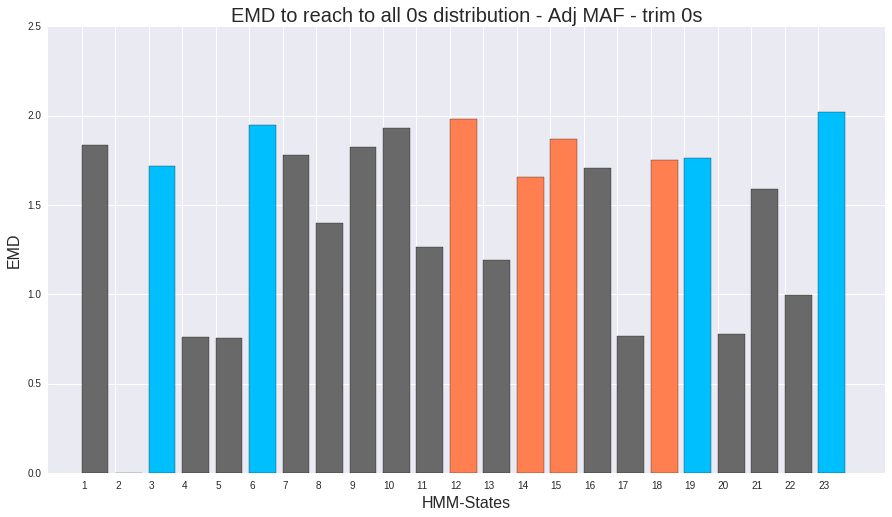

In [14]:
trim0s_maf_emd_dict = compute_pymed_emd(states_MAF_adj_dict_0s, 1000)
plot_emd(trim0s_maf_emd_dict, "Adj MAF - trim 0s", curr_dir, "SNP_Zinc_filter_JSD_Major_allele_EMD", True, False)

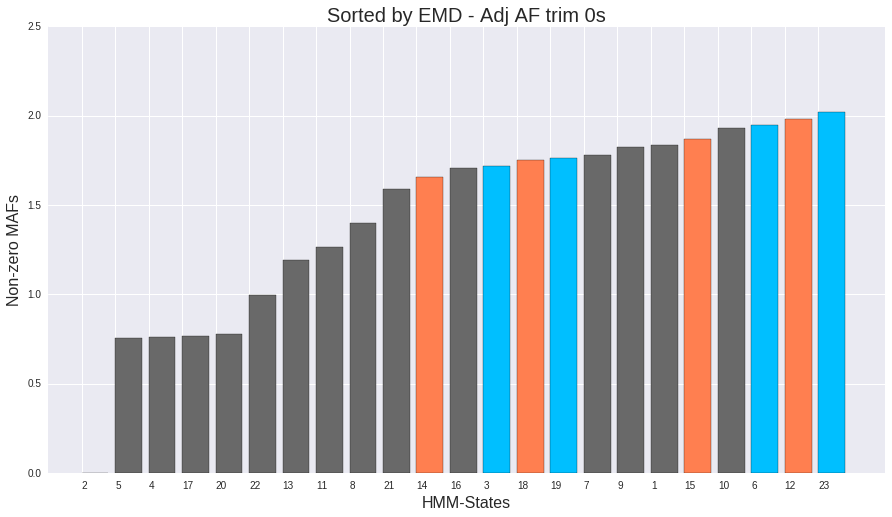

In [15]:
plot_sorted(trim0s_maf_emd_dict, "Sorted by EMD", "Adj AF trim 0s", curr_dir, "Sorted_EMD_MAF_Adj_filter", True, False)

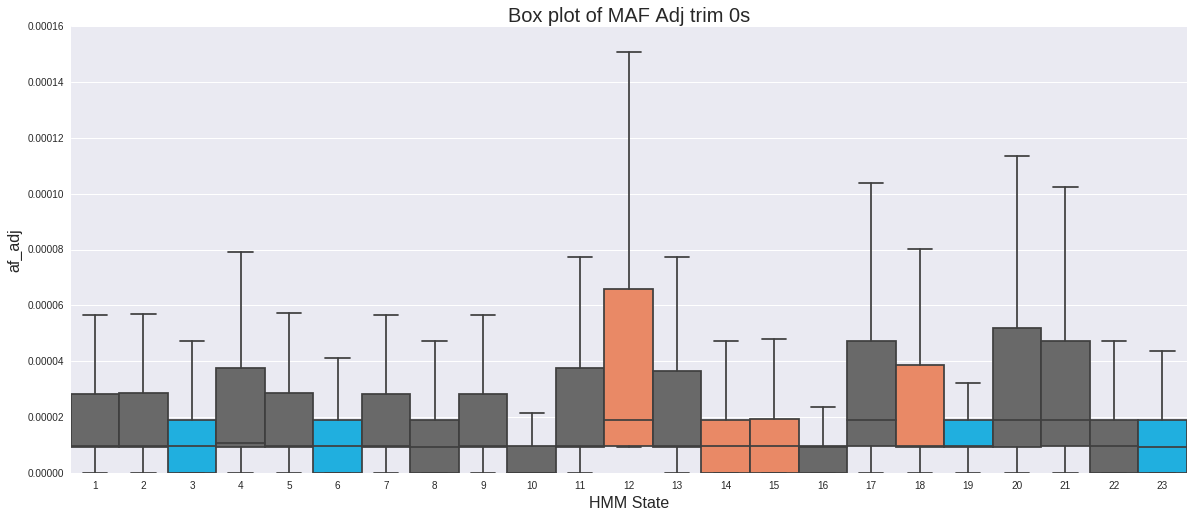

In [16]:
maf_adj_sns_table = create_sns_table_from_flat_dict(states_MAF_adj_dict_0s, "af_adj")
plot_box_plot(maf_adj_sns_table, states_MAF_adj_dict_0s.keys(), "af_adj", "Box plot of MAF Adj trim 0s", "box_plot_JSD_Adj_trim_0s", False)

### Trim 90% of 0s before EMD

In [17]:
#Count the number of zero Adj MAF
zero_adj_af = [0] * states_num
for state in states_dict.keys():
    for d in states_dict[state]:
        if (d["af_adj"] == 0):
            zero_adj_af[state-1] += 1

In [18]:
#Trim each state by the same % of 0 data points
trim_per = 0.9

states_dict_0s_per = states_dict.copy()
for state in states_dict_0s.keys():
    #Sort the state list
    state_sorted = sorted(states_dict_0s_per[state], key=lambda k: k['af_adj'])
    trim_num = int(np.round(zero_adj_af[state-1] * trim_per))
    states_dict_0s_per[state] = state_sorted[trim_num:]

In [19]:
#Create a dictionary for MAF adj values only
states_MAF_adj_dict_0s_per = defaultdict(list)
for state in states_dict_0s_per.keys():
    for d in states_dict_0s_per[state]:
        states_MAF_adj_dict_0s_per[state].append(d["af_adj"])

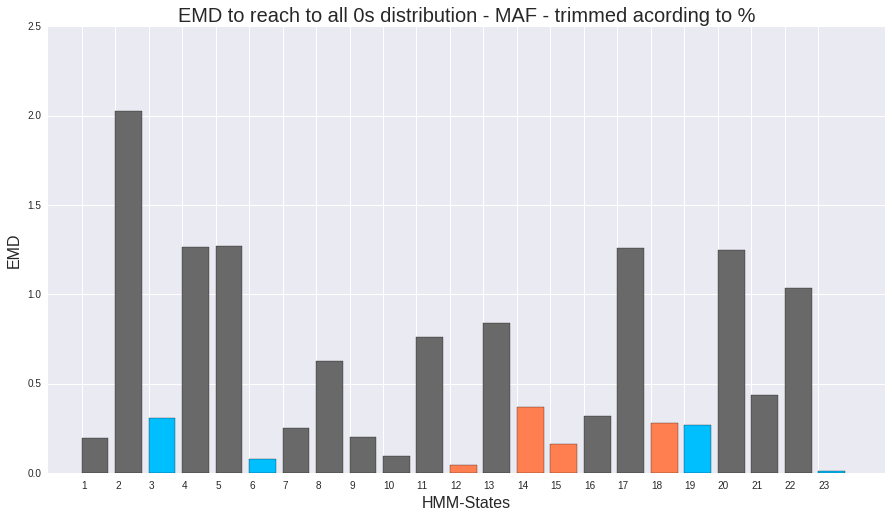

In [20]:
trim0s_per_MAF_emd_dict = compute_pymed_emd(states_MAF_adj_dict_0s_per, 1000)
plot_emd(trim0s_per_MAF_emd_dict, "MAF - trimmed acording to %", curr_dir, "SNP_Zinc_filter_JSD_Major_allele_EMD", False, False)

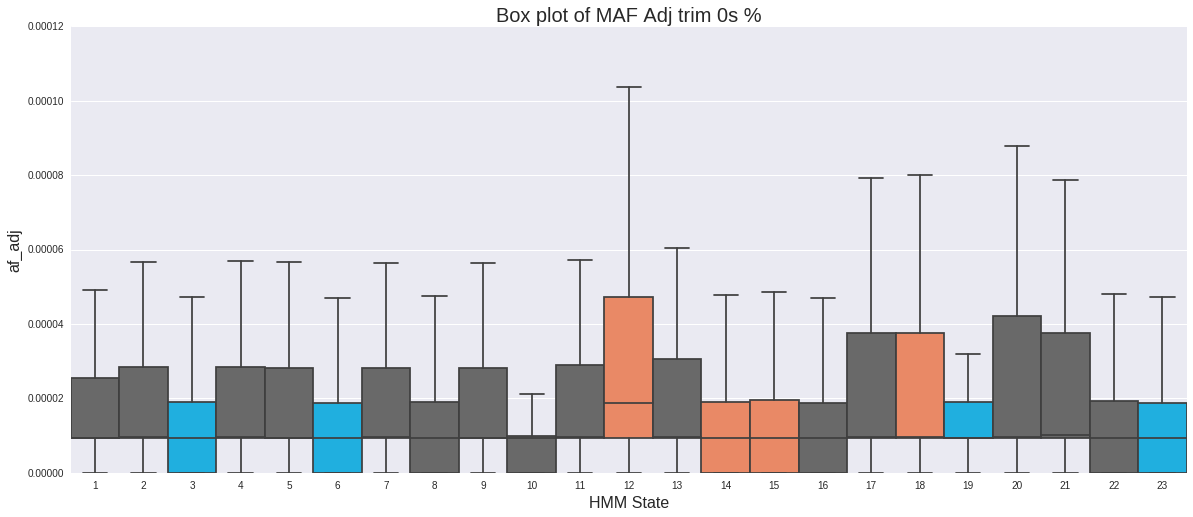

In [21]:
maf_adj_sns_table_per = create_sns_table_from_flat_dict(states_MAF_adj_dict_0s_per, "af_adj")
plot_box_plot(maf_adj_sns_table_per, states_MAF_adj_dict_0s.keys(), "af_adj", "Box plot of MAF Adj trim 0s %", "box_plot_JSD_Adj_trim_0s", False)

# Debugging code

### Plot States Average

In [113]:
avg_af_dict = {}
avg_af_adj_dict = {}
std_af_adj_dict = {}
for state in states_dict.keys():
    af_sum = 0
    af_adj_sum = 0
    af_adj_list = []
    
    for d in states_dict[state]:
        af_sum += d["af"]
        af_adj_sum += d["af_adj"]
        af_adj_list.append(d["af_adj"])
        
    af_avg = af_sum/float(len(states_dict[state]))
    af_adj_avg = af_adj_sum/float(len(states_dict[state]))
    std_af_adj_dict[state] = np.std(af_adj_list)
    avg_af_dict[state] = af_avg
    avg_af_adj_dict[state] = af_adj_avg

In [ ]:
#plt.figure(figsize=(15,8))
plt.bar(avg_af_dict.keys(), avg_af_dict.values())
plt.xticks(np.arange(1,states_num + 1), avg_af_dict.keys(), ha='left')
plt.xlabel("HMM-States")
plt.ylabel("AF average")
plt.title("Average AF of ExAC aligned to Zinc finger HMM states")
#plt.savefig(curr_dir[0]+"/EMD_plots/SNP_Homeobox_Avg.pdf")
plt.show()

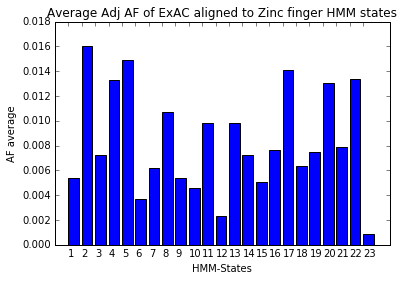

In [116]:
plt.bar(std_af_adj_dict.keys(), std_af_adj_dict.values())
plt.xticks(np.arange(1,states_num + 1), std_af_adj_dict.keys(), ha='left')
plt.xlabel("HMM-States")
plt.ylabel("AF average")
plt.title("Average Adj AF of ExAC aligned to Zinc finger HMM states")
plt.show()

In [16]:
sns.set_style("whitegrid", {'axes.grid' : False})

### EMD bins implementation

In [69]:
af_emd_bins_dict = compute_bins_emd(states_af_dict, 1000)
af_adj_emd_bins_dict = compute_bins_emd(states_af_adj_dict, 1000)

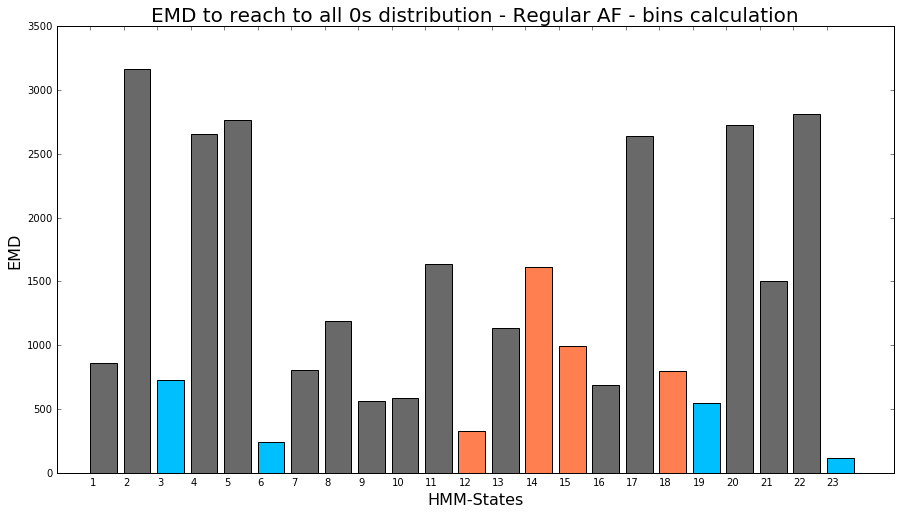

In [71]:
plot_emd(af_emd_bins_dict, "Regular AF - bins calculation", "")

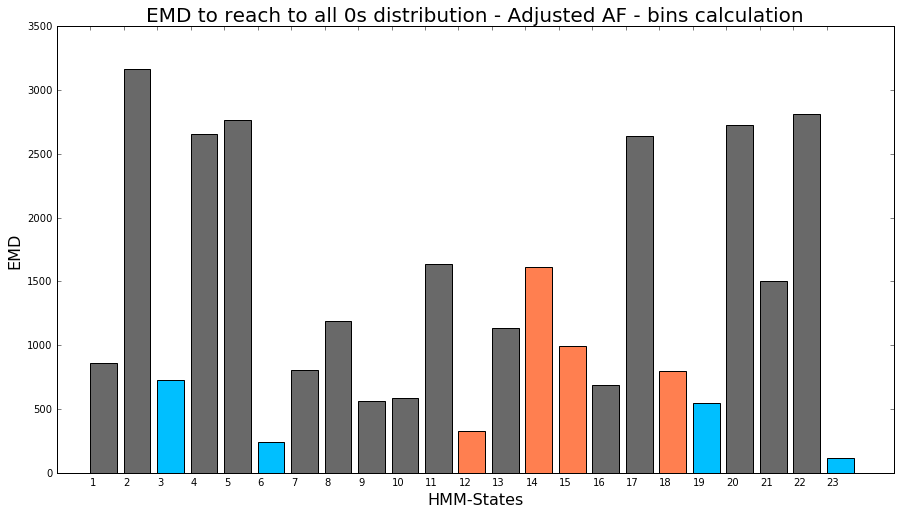

In [72]:
plot_emd(af_adj_emd_bins_dict, "Adjusted AF - bins calculation", "")

### Explore States distribution

In [75]:
non_zero_adj_af

[1116,
 1002,
 891,
 1074,
 1035,
 821,
 939,
 710,
 1017,
 475,
 1065,
 1247,
 958,
 804,
 914,
 650,
 1159,
 1033,
 974,
 1068,
 1204,
 838,
 754]

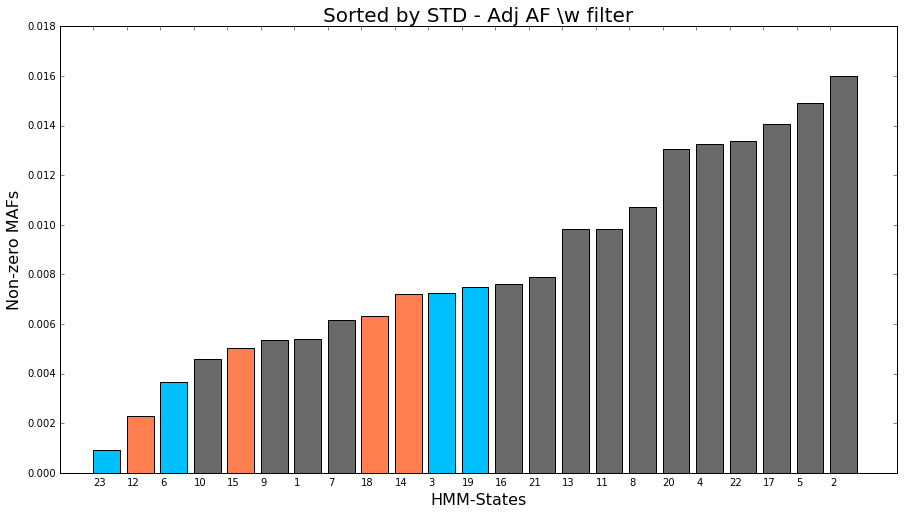

In [120]:
plot_sorted(std_af_adj_dict.values(), "Adj AF \w filter", "Sorted_STD_Adj_filter")

plt.bar(states_dict.keys(), non_zero_adj_af)
plt.xticks(np.arange(1,states_num + 1), avg_af_adj_dict.keys(), ha='left')
plt.xlabel("HMM-States")
plt.ylabel("Non-zero AF")
plt.title("Number of non-zero AF - missense mutations")
plt.show()

### Plot Scatter of AF and coverage

In [9]:
all_afs = []
all_mean_cov = []
for state in states_dict.keys():
    for i in range(len(states_dict[state])):
        all_afs.append(states_dict[state][i]["af"])
        all_mean_cov.append(states_dict[state][i]["coverage_mean"])

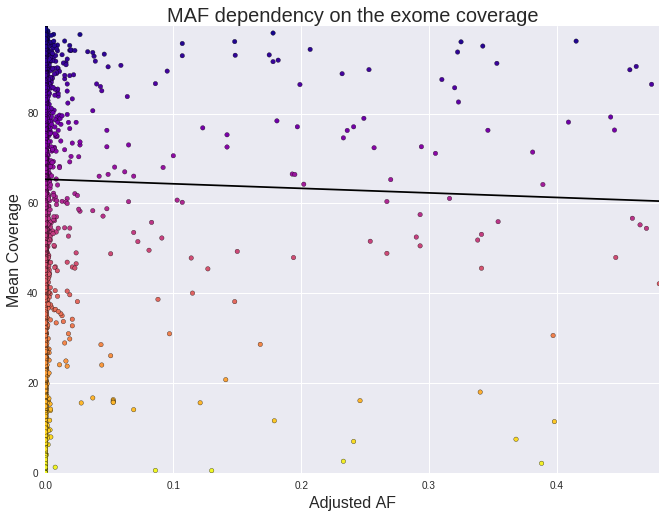

In [11]:
plot_scatter(all_afs, all_mean_cov, "MAF dependency on the exome coverage", "MAF_Cov_scatter")

### box plots

In [15]:
plt.figure(figsize=(15,8))
sns.set_style("whitegrid")
colors = ['dimgrey', 'dimgrey', 'deepskyblue', 'dimgrey', 'dimgrey', 'deepskyblue', 'dimgrey', 'dimgrey', 'dimgrey', 'dimgrey', 'dimgrey', 'coral', 
          'dimgrey', 'coral', 'coral', 'dimgrey', 'dimgrey', 'coral', 'deepskyblue', 'dimgrey', 'dimgrey', 'dimgrey', 'deepskyblue']

ax = sns.boxplot(x="state", y="coverage_mean", data=sns_table, width=1, palette=colors)
ax.set_xticklabels(states_dict.keys())

plt.xlabel("HMM State", fontsize=16)
plt.ylabel("MAF", fontsize=16)
plt.title("Box Plots of Coverage per state - Adj AF \w filter", fontsize=20)

plt.savefig(curr_dir[0]+"/plots/Cov_boxplot_Adj_filter.pdf")

plt.show()

NameError: name 'sns' is not defined